In [1]:
import os, cv2, glob, sys
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from tqdm  import tqdm
from datetime import datetime

import tensorflow as tf

# Add the upper level directory to the path
sys.path.append('..')
import imutils as im
sys.path.append('../Preprocessing')
from Preprocessing.preproc import beautify_frame

18 images loaded
Type of images:  <class 'numpy.ndarray'>


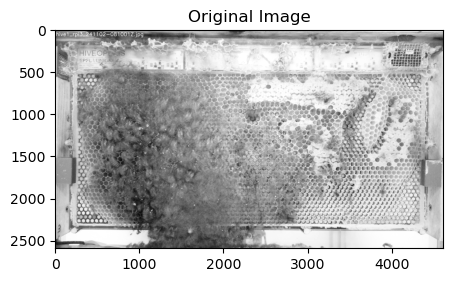

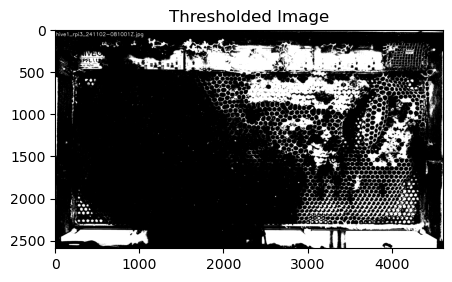

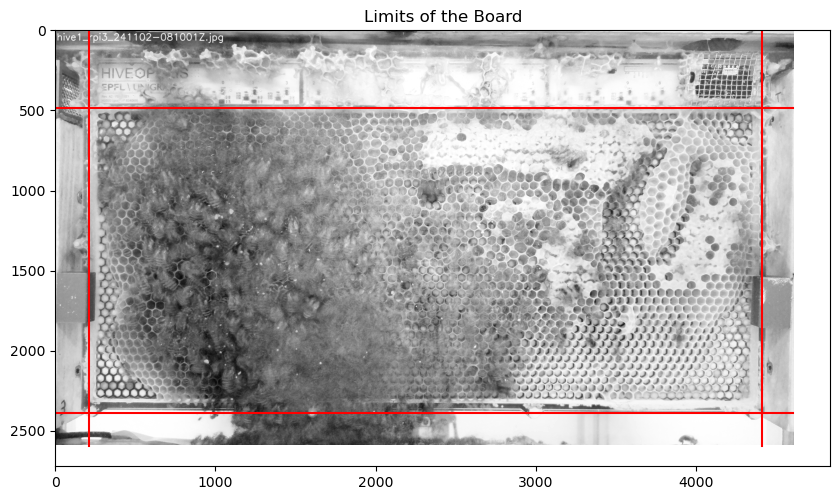

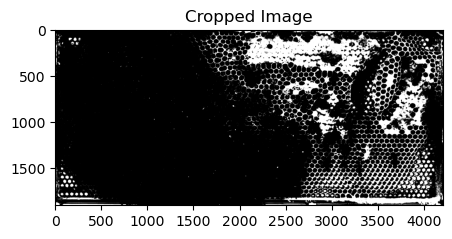

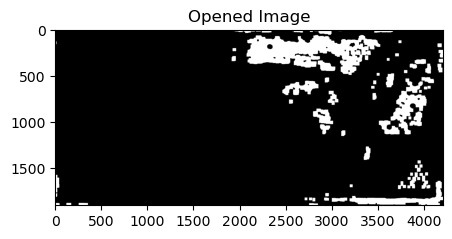

In [5]:
IDX_USED = 10
# Load the images in ../ForegroundRemoval/iLastikDataset
images = glob.glob('../ForegroundRemoval/iLastikDataset/*.jpg')
images = sorted(images)
images = [cv2.imread(img, cv2.IMREAD_GRAYSCALE) for img in images] 

print(len(images), 'images loaded')
print("Type of images: ", type(images[IDX_USED]))

# Show the first image
plt.figure(figsize=(5,5))
plt.imshow(images[IDX_USED], cmap='gray')
plt.title('Original Image')
plt.show()

def thresholding(img, threshold):
    # Apply a threshold to the image
    _, img = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    return img


th_img = thresholding(images[IDX_USED], 220)
plt.figure(figsize=(5,5))
plt.imshow(th_img, cmap='gray')
plt.title('Thresholded Image')
plt.show()

top, bot = im.findVerticalBoardLimits(images[IDX_USED])
left, right = im.findHorizontalBoardLimits(images[IDX_USED])

# Show the vertical limits of the board
plt.figure(figsize=(10,10))
plt.imshow(images[IDX_USED], cmap='gray')
plt.plot([0, images[IDX_USED].shape[1]], [bot, bot], 'r')
plt.plot([0, images[IDX_USED].shape[1]], [top, top], 'r')
plt.plot([left, left], [0, images[IDX_USED].shape[0]], 'r')
plt.plot([right, right], [0, images[IDX_USED].shape[0]], 'r')
plt.title('Limits of the Board')
plt.show()

# Crop the image to the board limits
cropped_img = th_img[top:bot, left:right]
plt.figure(figsize=(5,5))
plt.imshow(cropped_img, cmap='gray')
plt.title('Cropped Image')
plt.show()

# Use morphological operations to first close the gaps in the image then open the image to remove noise
kernel_close = np.ones((10,10), np.uint8)
kernel_open = np.ones((30,30), np.uint8)
closed_img = cv2.morphologyEx(cropped_img, cv2.MORPH_CLOSE, kernel_close)
opened_img = cv2.morphologyEx(closed_img, cv2.MORPH_OPEN, kernel_open)
plt.figure(figsize=(5,5))
plt.imshow(opened_img, cmap='gray')
plt.title('Opened Image')
plt.show()


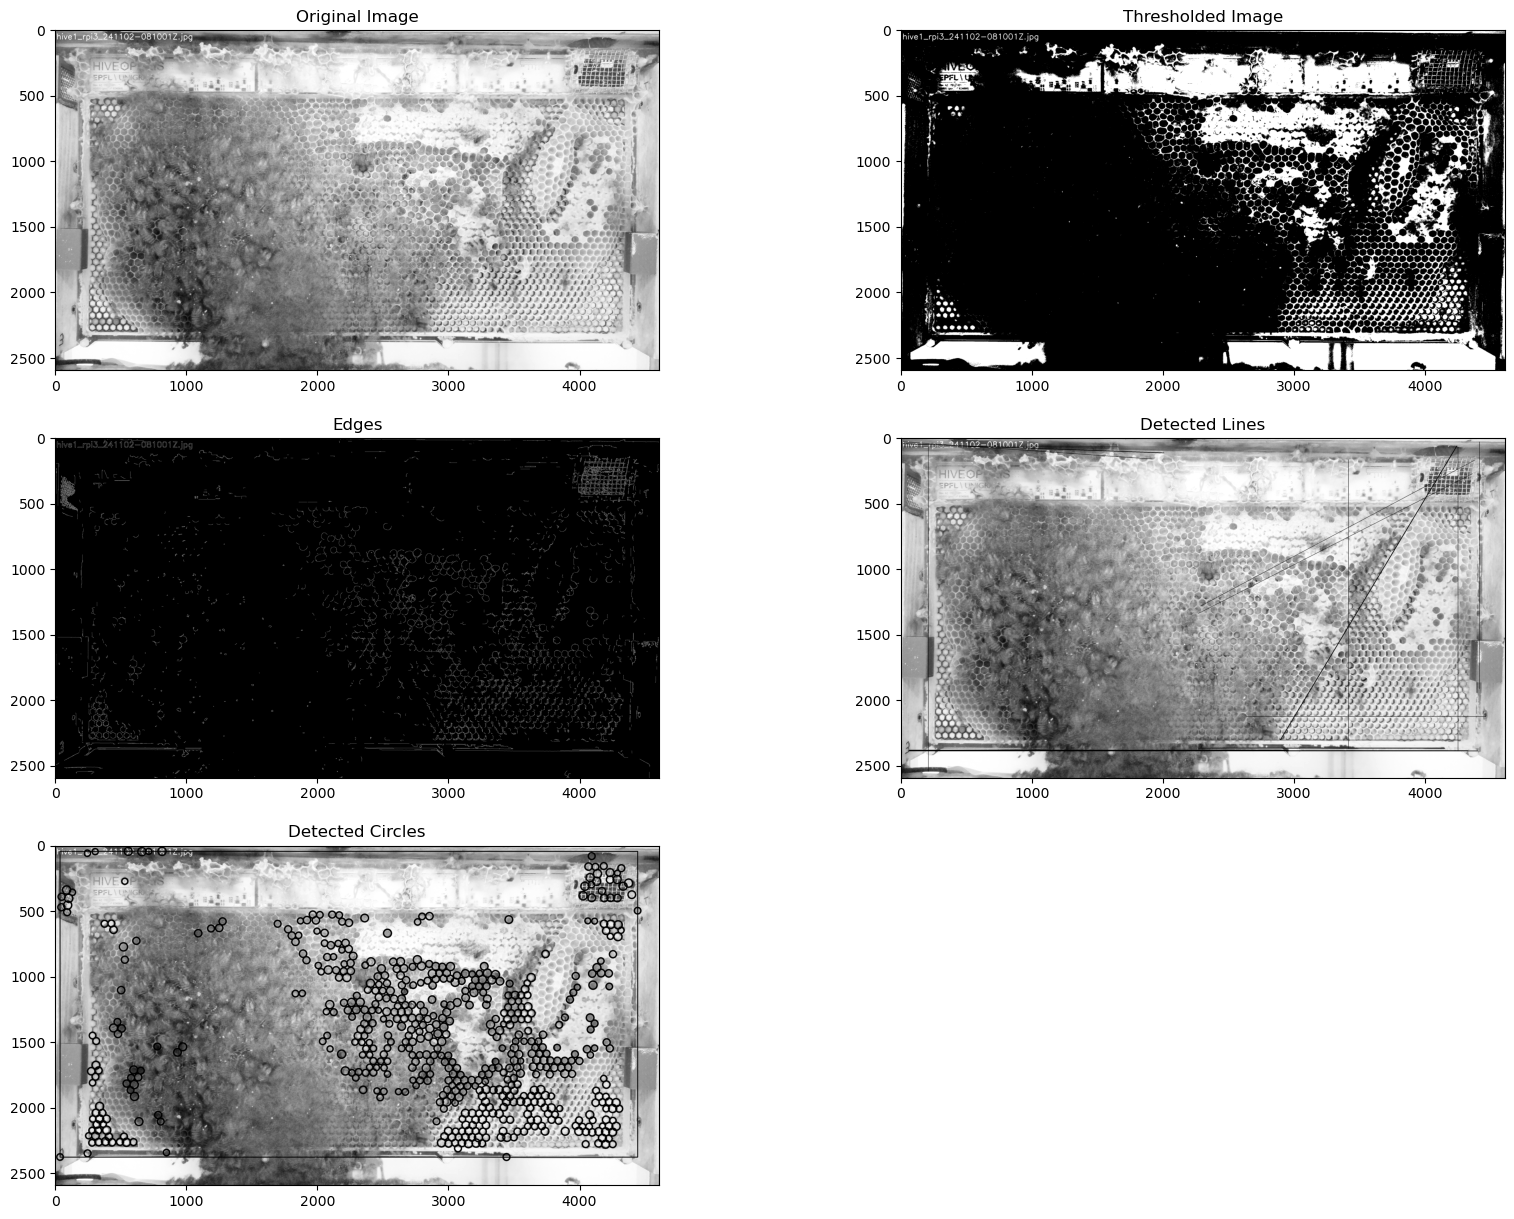

In [6]:
img = images[IDX_USED]
edges = cv2.Canny(img, 150, 400)
# Detect lines using Hough Transform
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=200, minLineLength=1600, maxLineGap=1000)
# Try to find circles in the edges
circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, dp=1, minDist=45, param1=300, param2=12, minRadius=22, maxRadius=32)
# Find the smallest rectangle that holds the most circles
if circles is not None:
    circles = np.uint16(np.around(circles))
    points = circles[0, :, :2]  # Extract (x, y) coordinates of circles
    x, y, w, h = cv2.boundingRect(points.astype(np.int32))
else:
    raise ValueError("No circles were detected, cannot compute bounding rectangle.")
x1_bb, y1_bb = x, y
x2_bb, y2_bb = x + w, y + h

# We need to find the rectangle that optimises the number of circles/area


plt.figure(figsize=(20, 15))
plt.subplot(3, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.subplot(3, 2, 2)
plt.imshow(th_img, cmap='gray')
plt.title('Thresholded Image')
plt.subplot(3, 2, 3)
plt.imshow(edges, cmap='gray')
plt.title('Edges')
plt.subplot(3, 2, 4)
img_copy = img.copy()
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(img_copy, cmap='gray')
plt.title('Detected Lines')
plt.subplot(3, 2, 5)
img_copy = img.copy()
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        cv2.circle(img_copy, (i[0], i[1]), i[2], (0, 0, 255), 10)
    cv2.rectangle(img_copy, (x1_bb, y1_bb), (x2_bb, y2_bb), (0, 255, 0), 5)

plt.imshow(img_copy, cmap='gray')
plt.title('Detected Circles')
plt.show()